Import necessary modules

In [1]:
import sys
sys.path.append("/net/server/homes/sep/ettore/research/packages/acoustic_isotropic_operators/test/lib/python/")
import genericIO
import SepVector
import Hypercube
import Acoustic_iso_double
import numpy as np
import time

import pyVector

Create wavelet and velocity model

In [2]:
!Wavelet n1=1001 d1=0.004 fund=10. tdelay=1. wavelet=ricker2 | Add scale=-1. > wlt.H

In [3]:
!Vel n1=560 d1=0.01 o1=0.0 n2=1904 d2=0.01 o2=0.0 n3=1 d3=0.01 o3=0.0 vc=2.0 | Pad beg1=5 end1=5 beg2=5 end2=5 > vel.H

Now lets start up genericIO read the files into memory

In [4]:
wavelet=genericIO.defaultIO.getVector("wlt.H")

In [5]:
velocity=genericIO.defaultIO.getVector("vel.H")

Lets make sure we've got got something reasonable


0.0


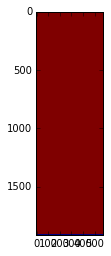

In [6]:
%matplotlib inline  
import matplotlib.pyplot as plt

print(velocity.getNdArray().min())
plt.imshow(velocity.getNdArray());

In [7]:
params={
"nts":1001,
"dts":0.004,
"sub":8,
"nz":570,
"nx":1914,
"zPadMinus":100,
"zPadPlus":110,
"xPadMinus":100,
"xPadPlus":104,
"dz":0.01,
"dx":0.01,
"fMax":16,
"zSource":10,
"xSource":850,
"nShot":50,
"spacingShots":1,
"depthReceiver":10,
"nReceiver":1700,
"dReceiver":1,
"oReceiver":1,
"saveWavefield":0,
"wavefieldShotNumber":0,
"blockSize":16,
"fat":5,
"nGpu":8}

Converting the velocity into double.

In [8]:
hyper=velocity.getHyper()
velDouble=SepVector.getSepVector(hyper,storage="dataDouble")
velDMat=velDouble.getNdArray()
velSMat=velocity.getNdArray()

for i2 in range(hyper.axes[1].n):
    for i1 in range(hyper.axes[0].n):
        velDMat[i2][i1]=velSMat[i2][i1]


Creating source vector

In [9]:
nzSource = 1;
ozSource =params["zSource"] - 1 + params["zPadMinus"] + params["fat"];
dzSource = 1;
nxSource = 1;
oxSource =params["xSource"] - 1 + params["xPadMinus"] + params["fat"];
dxSource = 1;
spacingShots = params["spacingShots"]
sourceVector=[]
for ishot in range(params["nShot"]):
    sourceVector.append(Acoustic_iso_double.deviceGpu(nzSource, ozSource, dzSource, nxSource, oxSource, dxSource, velDouble.getCpp(), params["nts"]))
    oxSource = oxSource + spacingShots;

Creating receiver vector

In [10]:
nzReceiver = 1;
ozReceiver = params["depthReceiver"] - 1 + params["zPadMinus"] + params["fat"];
dzReceiver = 1;
nxReceiver = params["nReceiver"]
oxReceiver = params["oReceiver"] - 1 + params["xPadMinus"] + params["fat"];
dxReceiver = params["dReceiver"];
                    
receiversVector=[]
nRecGeom = 1;# Constant receivers' geometry
for iRec in range(nRecGeom):
    receiversVector.append(Acoustic_iso_double.deviceGpu(nzReceiver, ozReceiver, dzReceiver, nxReceiver, oxReceiver, dxReceiver, velDouble.getCpp(), params["nts"]))


Convert the wavelet to double and convert it into 3DHyper

In [11]:
hyperTAxis=wavelet.getHyper().axes[0]
dumbAxis=Hypercube.axis(n=1)
modelHyper=Hypercube.hypercube(axes=[hyperTAxis,dumbAxis,dumbAxis])
waveletD=SepVector.getSepVector(modelHyper,storage="dataDouble")
waveDMat=waveletD.getNdArray()
waveSMat=wavelet.getNdArray()

for i1 in range(hyperTAxis.n):
    waveDMat[0][0][i1]=waveSMat[i1]

Now let's setup the data

In [12]:
receiverAxis=Hypercube.axis(n=nxReceiver, o=oxReceiver, d=dxReceiver)
sourceAxis=Hypercube.axis(n=params["nShot"], o=oxSource, d=dxSource)
dataD=SepVector.getSepVector(Hypercube.hypercube(axes=[hyperTAxis,receiverAxis,sourceAxis]),storage="dataDouble")
data=SepVector.getSepVector(Hypercube.hypercube(axes=[hyperTAxis,receiverAxis,sourceAxis]),storage="dataFloat")

We will use a dictionary for all the other parameters that might be needed.

In [13]:
paramP=genericIO.pythonParams(params)

Create simulation object

In [14]:
# propagator=Acoustic_iso_double.nonlinearPropShotsGpu(waveletD,dataD,velDouble,paramP,sourceVector,receiversVector)

In [15]:
# t0 = time.time()
# propagator.forward(False, waveletD, dataD);
# t1 = time.time()

# total = t1-t0
# print(total)

Plotting data

In [16]:
# %matplotlib inline  
# import matplotlib.pyplot as plt
# data = np.reshape(dataD.getNdArray()[0,:,:],(1700,1001))
# plt.imshow(data.T);

Dot-product test of propagator operator

In [17]:
# propagator.dotTest(True)

Testing Born operator

In [18]:
#Converting the wavelet from a 3DReg to a list of 2DReg
hyperTAxis=wavelet.getHyper().axes[0]
dumbAxis=Hypercube.axis(n=1)
modelHyper=Hypercube.hypercube(axes=[hyperTAxis,dumbAxis])
waveletDBorn=SepVector.getSepVector(modelHyper,storage="dataDouble")
waveDBornNp=np.array(waveletDBorn.getCpp(),copy=False)
waveDNp=np.array(waveletD.getCpp(),copy=False)
waveDBornNp[0,:]=waveDNp[0,0,:]
waveletDBorn=[waveletDBorn]

born_op=Acoustic_iso_double.BornShotsGpu(velDouble,dataD,velDouble,paramP,sourceVector,waveletDBorn,receiversVector)

Dot-product test for Born operator

In [19]:
# born_op.dotTest(True)
del born_op

Generating Born data to be inverted

In [20]:
#Creating background model
!Pad <velocityMarmousi.H beg1=105 end1=105 beg2=102 end2=102 extend=1 | Pad beg1=5 end1=5 beg2=5 end2=5 > velocityMarmousi.pad.H
!Smooth <velocityMarmousi.pad.H rect1=5 rect2=5 repeat=3 > background.pad.H
#Creating reflectivity
!Add velocityMarmousi.pad.H background.pad.H scale=1,-1 > reflectivity.pad.H

In [21]:
#Reading necessary files
background=genericIO.defaultIO.getVector("background.pad.H")
reflectivity=genericIO.defaultIO.getVector("reflectivity.pad.H")
#Converting to Double precision
backgroundD=SepVector.getSepVector(background.getHyper(),storage="dataDouble")
backgroundDNp=np.array(backgroundD.getCpp(),copy=False)
backgroundSNp=np.array(background.getCpp(),copy=False)
backgroundDNp[:]=backgroundSNp

reflectivityD=SepVector.getSepVector(reflectivity.getHyper(),storage="dataDouble")
reflectivityDNp=np.array(reflectivityD.getCpp(),copy=False)
reflectivitySNp=np.array(reflectivity.getCpp(),copy=False)
reflectivityDNp[:]=reflectivitySNp

backgroundD.norm(2)

2962.464599609375

In [22]:
born_op=Acoustic_iso_double.BornShotsGpu(reflectivityD,dataD,backgroundD,paramP,sourceVector,waveletDBorn,receiversVector)


In [23]:
born_op.forward(False,reflectivityD,dataD)

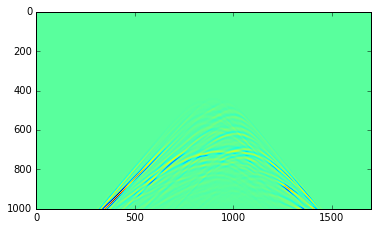

In [24]:
%matplotlib inline  
import matplotlib.pyplot as plt
data = np.reshape(dataD.getNdArray()[0,:,:],(1700,1001))
plt.imshow(data.T);

Inversion of Born Data

In [25]:
import pyLCGsolver as LCG
import pyProblem as Prblm
import pyStopperBase as Stopper

In [26]:
#Create L2-norm linear problem
model_vec = reflectivityD.clone()
model_vec.zero()
L2Prob = Prblm.ProblemL2Linear(model_vec,dataD,born_op)
#Create stopper
niter = 10
Stop  = Stopper.BasicStopper(niter=niter)
#Create solver
LCGsolver = LCG.LCGsolver(Stop)
LCGsolver.setDefaults(iter_buffer=None,iter_sampling=10)
#Running the solver
LCGsolver.run(L2Prob)

LINEAR CONJUGATE GRADIENT SOLVER
Restart folder: /tmp/restart_2019-01-07T11-19-17.788748/



TypeError: norm() missing 1 required positional argument: 'nrm'